Table of Contents

* <a href='#motivation'>Motivation</a>

* <a href='#constructor'>Constructing a dataset</a>

* <a href='#attributes'>Attributes</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Saving/reloading a dataset (Serialization)</a>

* <a href='#arithmetic'> Combining multiple datasets and arithmetic on useful subsets within datasets </a>

* <a href='#portability'>Exporting to numpy and portability (e.g. with sklearn)</a>

<a id='motivation'></a>

## A Python data structure to improve handling of datasets in machine learning workflows

This class is greatly suited for neuroimaging applications (or any other domain), where each sample needs to be uniquely identified with a subject ID (or something similar). 

Key-level correspondence across data, labels (1 or 2), classnames ('healthy', 'disease') and the related helps maintain data integrity and improve the provenance, in addition to enabling traceback to original sources from where the features have been originally derived.

Just to given you a concrete examples, let's look at how an ML dataset is handled traditionally.

You have a matrix X of size n x p, with n samples and p features, and a vector y containing the target values (or class labels or class identifiers). This X and y serves as training (and test set) for a classifier like SVM to fit the data X to match y as accurately as possible.

Let's get a little more concrete:

In [112]:
import sys, os
import numpy as np
import matplotlib
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

n = 10 # number of samples
p = 3  # number of features

X = np.random.random([n, p]) # random data for illustration
y = [1]*5 + [2]*5            # random labels ...

np.set_printoptions(precision=2) # save some screen space
print 'X : \n', X
print 'y : \n', y

Using matplotlib backend: TkAgg
X : 
[[ 0.64  0.48  0.88]
 [ 0.19  0.05  0.12]
 [ 0.13  0.1   0.68]
 [ 0.99  0.19  0.39]
 [ 0.86  0.36  0.91]
 [ 0.83  0.98  0.32]
 [ 0.86  0.35  0.3 ]
 [ 0.32  0.65  0.83]
 [ 0.6   0.75  0.53]
 [ 0.12  0.52  0.41]]
y : 
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


Almost all the machine learning toolboxes take their input in this form: X and y, regardless of the original source that produced these features in the first place.

This is all fine if all you ever wanted to do is to extract some features, do some machine learning and dispose these features away! 

** But this is almost never the case!**

Because it doesn't simply end there.

At a minimum, I often need to know 
 * which samples are misclassified - meaning you need to know what the identifiers are and not simply their row indices in X?
 * what are the charecteristics of those samples?
 * what classes do they belong to?


And all this info needs to be obtained
 * without having to write lots of code connecting few non-obvious links to disparate sources of data (numerical features X, and sample identifiers in a CSV file) to find the relevant info
 * without having to track down who or which method originally produced these features
 * how the previous personnel or grad student organized the whole dataset, if you haven't generated the features yourself from scratch

And if you are like me, you would be thinking about how would you organize your workflow such that the aforementioned tasks can be accomplished with ease.
 
This data structure attempts to accomplish that with ease. By always organizing the extracted features keyed-in into a dictionary with their *sample id*, and other important info such as *target values* and other identified info. This, by definition, preserves the integrity of the data (inability to incorrectly label samples etc).

No, this data structure doesn't offer the full [provenance tracking](http://rrcns.readthedocs.io/en/latest/provenance_tracking.html), which is quite a challenging problem. But it tries make your life a little easier in your ML workflows.

An example application is shown below, touching upon the following topics:

* <a href='#motivation'>Motivation</a>

* <a href='#constructor'>Constructing a dataset</a>

* <a href='#attributes'>Attributes</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Saving/reloading a dataset (Serialization)</a>

* <a href='#arithmetic'> Combining multiple datasets and arithmetic on useful subsets within datasets </a>

* <a href='#portability'>Exporting to numpy and portability (e.g. with sklearn)</a>

Improting the necessary modules and our fancy class definition:

In [113]:
from pyradigm import MLDataset

We can now instantiate it and give it a description:

In [114]:
dataset = MLDataset()
dataset.description = 'ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.'

In [115]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
Empty dataset.

You can see the dataset some description attached to it, however we know it is empty. This can be verified in a boolean context as shown below:

In [116]:
bool(dataset)

False

Let's add samples to this dataset which is when this dataset implementation becomes really handy. Before we do that, we will define some convenience routines defined to just illustrate a simple yet common use of this dataset.

In [117]:
def read_thickness(path):
    """Dummy function to minic a data reader."""

    # in your actural routine, this might be:
    #   pysurfer.read_thickness(path).values()
    return np.random.random(2)


def get_features(work_dir, subj_id):
    """Returns the whole brain cortical thickness for a given subject ID."""

    # extension to identify the data file; this could be .curv, anything else you choose
    ext_thickness = '.thickness'

    thickness = dict()
    for hemi in ['lh', 'rh']:
        path_thickness = os.path.join(work_dir, subj_id, hemi + ext_thickness)
        thickness[hemi] = read_thickness(path_thickness)

    # concatenating them to build a whole brain feature set
    thickness_wb = np.concatenate([thickness['lh'], thickness['rh']])

    return thickness_wb

So now we have IO routines to read the data for us. Let's define where the data will come from:

In [118]:
work_dir = '/project/ADNI/FreesurferThickness_v4p3'
class_set = ['Cntrl', 'Alzmr', 'MCI']
class_sizes = [15, 12, 18]

This would obviously change for your applications, but this has sufficient properties to illustrate the point.

Let's look at what methods this dataset offers us:

In [119]:
dir(dataset)

['add_classes',
 'add_sample',
 'class_set',
 'class_sizes',
 'classes',
 'data',
 'data_and_labels',
 'del_sample',
 'description',
 'extend',
 'get_class',
 'get_feature_subset',
 'get_subset',
 'glance',
 'keys',
 'num_classes',
 'num_features',
 'num_samples',
 'random_subset',
 'random_subset_ids',
 'random_subset_ids_by_count',
 'sample_ids',
 'sample_ids_in_class',
 'save',
 'summarize_classes',
 'train_test_split_ids']

<a id='constructor'></a>

## Constructor

You can see there few methods such as add_sample, get_subset etc: important method being add_sample, which is key to constructing this dataset. Let's go ahead and some samples:

In [120]:
import random
from datetime import datetime
random.seed(datetime.now())

def read_target_list(class_name, class_size):
    "Generates a random target list. In reality, you would do something like the commented code below."
    target_list = list()
    for idx in range(class_size):
        target_list.append('{}{:04d}'.format(class_name[0],np.random.randint(1000)))
        
    return target_list

#     target_list_path = os.path.join(work_dir,'scripts','test_sample.{}'.format(class_name))
#     with open(target_list_path,'r') as tf:
#         target_list = tf.readlines()
#         target_list = [sub.strip() for sub in target_list]

In [121]:
for class_index, class_id in enumerate(class_set):
    print('Working on class {:>5}'.format(class_id))

    target_list = read_target_list(class_id,class_sizes[class_index])
    for subj_id in target_list:
        print('\t reading subject {:>15}'.format(subj_id))
        thickness_wb = get_features(work_dir, subj_id)

        # adding the sample to the dataset
        dataset.add_sample(subj_id, thickness_wb, class_index, class_id)

Working on class Cntrl
	 reading subject           C0102
	 reading subject           C0589
	 reading subject           C0246
	 reading subject           C0776
	 reading subject           C0483
	 reading subject           C0622
	 reading subject           C0547
	 reading subject           C0296
	 reading subject           C0981
	 reading subject           C0782
	 reading subject           C0767
	 reading subject           C0451
	 reading subject           C0065
	 reading subject           C0592
	 reading subject           C0665
Working on class Alzmr
	 reading subject           A0502
	 reading subject           A0851
	 reading subject           A0402
	 reading subject           A0460
	 reading subject           A0166
	 reading subject           A0264
	 reading subject           A0866
	 reading subject           A0375
	 reading subject           A0971
	 reading subject           A0624
	 reading subject           A0153
	 reading subject           A0735
Working on class   MCI
	 reading sub

**Nice. Isn't it?**

So what's nice about this, you say? *The simple fact that you are constructing a dataset as you read the data* in its most elemental form (in the units of the dataset such as the subject ID in our neuroimaging application). You're done as soon as you're done reading the features from disk.

What's more - you can inspect the dataset in an intuitive manner, as shown below:

In [122]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples and 4 features.
Class Cntrl : 15 samples.
Class   MCI : 18 samples.
Class Alzmr : 12 samples.

Even better, right? No more too much typing of several commands to get the complete and concise sense of the dataset.

<a id='attributes'></a>

## Convenient attributes

If you would like, you can always get more specific information, such as:

In [123]:
dataset.num_samples

45

In [124]:
dataset.num_features

4

In [125]:
dataset.class_set

['Cntrl', 'MCI', 'Alzmr']

In [126]:
dataset.class_sizes

Counter({'Alzmr': 12, 'Cntrl': 15, 'MCI': 18})

In [127]:
dataset.class_sizes['Cntrl']

15

If you'd like to take a look data inside for few subjects - shall we call it a glance?

In [128]:
dataset.glance()

{'C0102': array([ 0.06,  0.16,  0.8 ,  0.9 ]),
 'C0246': array([ 0.93,  0.91,  0.09,  0.62]),
 'C0483': array([ 0.27,  0.97,  0.84,  0.63]),
 'C0589': array([ 0.34,  0.06,  0.33,  0.24]),
 'C0776': array([ 0.67,  0.06,  0.08,  0.03])}

We can control the number of items to glance, by passing a number to dataset.glance() method:

In [129]:
dataset.glance(2)

{'C0102': array([ 0.06,  0.16,  0.8 ,  0.9 ]),
 'C0589': array([ 0.34,  0.06,  0.33,  0.24])}

Or you may be wondering what are the subject IDs in the dataset.. here they are:

In [130]:
dataset.sample_ids

['C0102',
 'C0589',
 'C0246',
 'C0776',
 'C0483',
 'C0622',
 'C0547',
 'C0296',
 'C0981',
 'C0782',
 'C0767',
 'C0451',
 'C0065',
 'C0592',
 'C0665',
 'A0502',
 'A0851',
 'A0402',
 'A0460',
 'A0166',
 'A0264',
 'A0866',
 'A0375',
 'A0971',
 'A0624',
 'A0153',
 'A0735',
 'M0450',
 'M0207',
 'M0647',
 'M0752',
 'M0037',
 'M0171',
 'M0173',
 'M0733',
 'M0551',
 'M0698',
 'M0256',
 'M0642',
 'M0924',
 'M0543',
 'M0751',
 'M0950',
 'M0143',
 'M0670']

<a id='iteration'></a>

## Iteration over samples

Thanks to its dictionary based implementation, data for a given sample '007_S_1248' can simply be obtained by:

In [131]:
sample_id = dataset.sample_ids[20]
print sample_id, dataset.data[sample_id]

A0264 [ 0.63  0.14  0.23  0.15]


we can easily iterate over all the samples to obtain their data as well as class labels. Let's see it in action:

In [132]:
for sample, features in dataset.data.items():
    print "{} : {:>10} : {}".format(sample, dataset.classes[sample], features)

C0102 :      Cntrl : [ 0.06  0.16  0.8   0.9 ]
C0589 :      Cntrl : [ 0.34  0.06  0.33  0.24]
C0246 :      Cntrl : [ 0.93  0.91  0.09  0.62]
C0776 :      Cntrl : [ 0.67  0.06  0.08  0.03]
C0483 :      Cntrl : [ 0.27  0.97  0.84  0.63]
C0622 :      Cntrl : [ 0.4   0.53  0.08  0.53]
C0547 :      Cntrl : [ 0.66  0.49  0.45  0.68]
C0296 :      Cntrl : [ 0.32  0.33  0.21  0.52]
C0981 :      Cntrl : [ 0.51  0.09  0.93  0.91]
C0782 :      Cntrl : [ 0.12  0.42  0.2   0.65]
C0767 :      Cntrl : [ 0.59  0.18  0.26  0.77]
C0451 :      Cntrl : [ 0.2   0.08  0.25  0.18]
C0065 :      Cntrl : [ 1.    0.56  0.71  0.6 ]
C0592 :      Cntrl : [ 0.05  0.48  0.28  0.57]
C0665 :      Cntrl : [ 0.87  0.07  0.62  0.68]
A0502 :      Alzmr : [ 0.57  0.69  0.23  0.17]
A0851 :      Alzmr : [ 0.06  0.71  0.86  0.66]
A0402 :      Alzmr : [ 0.9   0.54  0.6   0.2 ]
A0460 :      Alzmr : [ 0.75  0.71  0.19  0.46]
A0166 :      Alzmr : [ 0.14  0.54  0.01  0.09]
A0264 :      Alzmr : [ 0.63  0.14  0.23  0.15]
A0866 :      

Thanks to the choice of the OrderedDict() for each of the data, classes and labels, the order of sample addition is retained. Hence the correspondence across samples in the dataset not only key-wise (by the sample id), but also index-wise.

Another example to illustrate how one can access the subset of features e.g. cortical thickness for a particular region of interest (say posterior cingulate gyrus) is below:

In [133]:
# let's make a function to return the indices for the ROI
def get_ROI_indices(ctx_label=None):
    if ctx_label == 'post_cingulate_gyrus':
        return xrange(2) # dummy for now
    else:
        return xrange(dataset.num_features) # all the features

Now the following code iterates over each sample and prints the average cortical thickness in the specific ROI:

In [134]:
avg_thickness = dict()
for sample, features in dataset.data.items():
    avg_thickness[sample] = np.mean(features[get_ROI_indices('post_cingulate_gyrus')])
    print "{} {:>10}  {:.2f}".format(sample, dataset.classes[sample], avg_thickness[sample] )

C0102      Cntrl  0.11
C0589      Cntrl  0.20
C0246      Cntrl  0.92
C0776      Cntrl  0.36
C0483      Cntrl  0.62
C0622      Cntrl  0.46
C0547      Cntrl  0.58
C0296      Cntrl  0.32
C0981      Cntrl  0.30
C0782      Cntrl  0.27
C0767      Cntrl  0.39
C0451      Cntrl  0.14
C0065      Cntrl  0.78
C0592      Cntrl  0.27
C0665      Cntrl  0.47
A0502      Alzmr  0.63
A0851      Alzmr  0.39
A0402      Alzmr  0.72
A0460      Alzmr  0.73
A0166      Alzmr  0.34
A0264      Alzmr  0.38
A0866      Alzmr  0.52
A0375      Alzmr  0.77
A0971      Alzmr  0.63
A0624      Alzmr  0.37
A0153      Alzmr  0.60
A0735      Alzmr  0.41
M0450        MCI  0.27
M0207        MCI  0.71
M0647        MCI  0.35
M0752        MCI  0.61
M0037        MCI  0.44
M0171        MCI  0.40
M0173        MCI  0.77
M0733        MCI  0.78
M0551        MCI  0.41
M0698        MCI  0.77
M0256        MCI  0.42
M0642        MCI  0.54
M0924        MCI  0.40
M0543        MCI  0.67
M0751        MCI  0.25
M0950        MCI  0.88
M0143      

Let's make a bar plot with the just computed numbers:

In [135]:
avg_thickness.values()

[0.77419317627756634,
 0.274568477535865,
 0.52456600133438958,
 0.10988851639242048,
 0.9173077195848538,
 0.67215738787506218,
 0.78073124498823832,
 0.34319836534987225,
 0.36466613282060334,
 0.40681014189609904,
 0.77075603570250351,
 0.2672873843477836,
 0.3979586538904154,
 0.41057586141404956,
 0.24687851327074922,
 0.54467083900315094,
 0.63490203247374355,
 0.26986173065211588,
 0.35136691981491958,
 0.38601865045543871,
 0.57797853866707183,
 0.60791732543673671,
 0.41977590274138665,
 0.77760363600740945,
 0.13930958880564798,
 0.37157580525743594,
 0.47605248855507931,
 0.70524233745725029,
 0.59765881251299779,
 0.71813681129356643,
 0.47074880969405297,
 0.38743449904671035,
 0.46419007761963849,
 0.6215589295056978,
 0.1986440118547006,
 0.29957866524180221,
 0.32234483765792193,
 0.7273392116680899,
 0.63002920038567556,
 0.88383304529760121,
 0.40282387477340864,
 0.44243699049296453,
 0.77499920202425088,
 0.38313913682247508,
 0.64471408195318269]

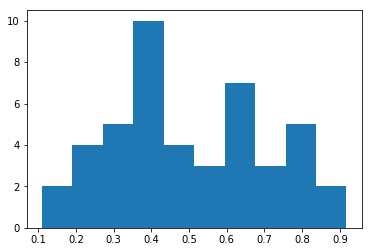

In [136]:
n, bins, patches = plt.hist(avg_thickness.values())

Remember as the original source of data was random, this has no units, property or meaning!

<a id='subsetselection'></a>

## Subset selection

In addition to the structured way of obtaining the various properties of this dataset, this implementation really will come in handy when you have to slice and dice the dataset (with large number of classes and features) into smaller subsets (e.g. for binary classification). Let's see how we can retrieve the data for a single class:

In [137]:
ctrl = dataset.get_class('Cntrl')

That's it, obtaining the data for a given class is a simple call away.

Now let's see what it looks like:

In [138]:
ctrl


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
15 samples and 4 features.
Class Cntrl : 15 samples.

Even with updated description automatically, to indicate its history. Let's see some data from controls:

In [139]:
ctrl.glance(2)

{'C0102': array([ 0.06,  0.16,  0.8 ,  0.9 ]),
 'C0589': array([ 0.34,  0.06,  0.33,  0.24])}

We can also query a random subset of samples for manual inspection or cross-validation purposes. For example:

In [140]:
random_subset = dataset.random_subset(perc_in_class=0.3)
random_subset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
12 samples and 4 features.
Class Cntrl : 4 samples.
Class   MCI : 5 samples.
Class Alzmr : 3 samples.

You can see which samples were selected:

In [141]:
random_subset.sample_ids

['C0296',
 'C0981',
 'C0592',
 'C0665',
 'A0402',
 'A0460',
 'A0866',
 'M0207',
 'M0752',
 'M0924',
 'M0543',
 'M0143']

You can verify that it is indeed random by issuing another call:

In [142]:
# supplying a new seed everytime to ensure randomization
from datetime import datetime
dataset.random_subset(perc_in_class=0.3).sample_ids

['C0102',
 'C0589',
 'C0547',
 'C0767',
 'A0851',
 'A0166',
 'A0375',
 'M0450',
 'M0207',
 'M0551',
 'M0698',
 'M0751']

#### Let's see how we can retrieve specific samples by their IDs (for which there are many use cases):

In [143]:
data = dataset.get_subset(dataset.sample_ids[1:20])
data


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
19 samples and 4 features.
Class Cntrl : 14 samples.
Class Alzmr : 5 samples.

So as simple as that.

# Cross-validation

If you would like to develop a variant of cross-validation, and need to obtain a random split of the dataset to obtain training and test sets, it is as simple as: 

In [144]:
train_set, test_set = dataset.train_test_split_ids( train_perc = 0.5)

This method returns two sets of sample ids corresponding to training set (which 50% of samples from all classes in the dataset) and the rest in test_set. Let's see what they have:

In [145]:
train_set, test_set

(['C0592',
  'C0622',
  'C0782',
  'C0776',
  'C0451',
  'C0483',
  'C0981',
  'M0752',
  'M0173',
  'M0543',
  'M0642',
  'M0751',
  'M0256',
  'M0207',
  'M0143',
  'M0924',
  'A0851',
  'A0402',
  'A0502',
  'A0971',
  'A0264',
  'A0624'],
 ['M0450',
  'A0866',
  'C0102',
  'C0246',
  'M0733',
  'A0166',
  'M0551',
  'M0698',
  'A0735',
  'M0647',
  'C0547',
  'C0065',
  'A0153',
  'C0665',
  'C0767',
  'C0589',
  'C0296',
  'A0460',
  'A0375',
  'M0171',
  'M0950',
  'M0037',
  'M0670'])

We can also get a train/test split by specifying an exact number of subjects we would like from each class (e.g. when you would like to avoid class imbalance in the training set):

In [146]:
train_set, test_set = dataset.train_test_split_ids( count_per_class = 3)

Let's see what the training set contains - we expect 3*3 =9 subjects :

In [147]:
train_set

['C0776',
 'C0065',
 'C0483',
 'M0173',
 'M0752',
 'M0698',
 'A0166',
 'A0624',
 'A0460']

We can indeed verify that is the case, by creating a new smaller dataset from that list of ids and getting a summary:

In [148]:
training_dataset = dataset.get_subset(train_set)
training_dataset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
9 samples and 4 features.
Class Cntrl : 3 samples.
Class   MCI : 3 samples.
Class Alzmr : 3 samples.

Another programmatic way to look into different classes is this:

In [149]:
class_set, label_set, class_sizes = training_dataset.summarize_classes()
class_set, label_set, class_sizes

(['Cntrl', 'MCI', 'Alzmr'], [0, 2, 1], array([ 3.,  3.,  3.]))

which returns all the classes that you could iterative over.

Using these two lists, we can easily obtain subset datasets, as illustrated below.

In [150]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples and 4 features.
Class Cntrl : 15 samples.
Class   MCI : 18 samples.
Class Alzmr : 12 samples.

In [151]:
binary_dataset = dataset.get_class(['Cntrl','Alzmr'])
binary_dataset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples and 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

How about selecting a subset of features from all samples?

In [152]:
binary_dataset.get_feature_subset(xrange(2))

Subset features derived from: 
 
 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples and 2 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

**Great.** Isn't it? You can also see the two-time-point history (initial subset in classes, followed by a subset in features).

<a id='serialization'></a>

## Serialization

Once you have this dataset, you can save and load these trivially using your favourite serialization module. Let's do some pickling:

In [153]:
out_file = os.path.join(work_dir,'binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.pkl')
binary_dataset.save(out_file)

That's it - it is saved.

Let's reload it from disk and make sure we can indeed retrieve it:

In [154]:
reloaded = MLDataset(filepath=out_file) # another form of the constructor!

Loading the dataset from: /project/ADNI/FreesurferThickness_v4p3/binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.pkl


In [155]:
reloaded


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples and 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

<a id='arithmetic'></a>

## Dataset Arithmetic

You might wonder how can you combine two different types of features ( thickness and shape ) from the dataset. Piece of cake, see below ...

To concatenat two datasets, first we make a second dataset:

In [156]:
dataset_two = MLDataset(in_dataset=dataset) # yet another constructor: in its copy form!

How can you check if they are "functionally identical"? As in same keys, same data and classes for each key... Easy:

In [157]:
dataset_two == dataset

True

Now let's try the arithmentic:

In [158]:
combined = dataset + dataset_two

Identical keys found. Trying to horizontally concatenate features for each sample.


Great. The add method recognized the identical set of keys and performed a horiz cat, as can be noticed by the twice the number of features in the combined dataset:

In [159]:
combined


45 samples and 8 features.
Class Cntrl : 15 samples.
Class   MCI : 18 samples.
Class Alzmr : 12 samples.

We can also do some removal in similar fashion:

In [160]:
smaller = combined - dataset

C0102 removed.
C0589 removed.
C0246 removed.
C0776 removed.
C0483 removed.
C0622 removed.
C0547 removed.
C0296 removed.
C0981 removed.
C0782 removed.
C0767 removed.
C0451 removed.
C0065 removed.
C0592 removed.
C0665 removed.
A0502 removed.
A0851 removed.
A0402 removed.
A0460 removed.
A0166 removed.
A0264 removed.
A0866 removed.
A0375 removed.
A0971 removed.
A0624 removed.
A0153 removed.
A0735 removed.
M0450 removed.
M0207 removed.
M0647 removed.
M0752 removed.
M0037 removed.
M0171 removed.
M0173 removed.
M0733 removed.
M0551 removed.
M0698 removed.
M0256 removed.
M0642 removed.
M0924 removed.
M0543 removed.
M0751 removed.
M0950 removed.
M0143 removed.
M0670 removed.


Data structure is even producing a warning to let you know the resulting output would be empty! We can verify that:

In [161]:
bool(smaller)

False

<a id='portability'></a>

## Portability

This is all well and good. How does it interact with other packages out there, you might ask? It is as simple as you can imagine:

In [162]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

In [163]:
data_matrix, target, sample_ids = binary_dataset.data_and_labels()
clf.fit(data_matrix, target)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

There you have it, a simple example to show you the utility and convenience of this dataset.

### Thanks for checking it out. 

### I would appreciate if you could give me feedback on improving or sharpening it further.